# LowCarb thorax disease classification in Flower

## Check GPU availability

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Oct 21 14:33:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    46W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Create dirs, get data 

In [3]:
# !mkdir NIH
# !mkdir /root/.kaggle/

### Copy Kaggle API-key to created directory at '/root/.kaggle'

In [2]:
# !cp '/content/drive/MyDrive/professional/Research_Jobs/UMI/projects/APIs/kaggle.json' '/root/.kaggle'

In [3]:
# !kaggle datasets download -d nih-chest-xrays/data

In [4]:
# !unzip -q '/content/data.zip' -d '/content/NIH/'

## Install packages

In [8]:
!pip install flwr[simulation]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 3.9 MB/s 
     |████████████████████████████████| 1.0 MB 29.5 MB/s 
     |████████████████████████████████| 54.5 MB 116.2 MB/s 
     |████████████████████████████████| 8.8 MB 40.8 MB/s 
     |████████████████████████████████| 4.1 MB 11 kB/s 
     |████████████████████████████████| 57 kB 6.0 MB/s 
     |████████████████████████████████| 201 kB 86.0 MB/s 
     |████████████████████████████████| 3.0 MB 74.3 MB/s 
     |████████████████████████████████| 90 kB 12.0 MB/s 
     |████████████████████████████████| 128 kB 80.5 MB/s 
     |████████████████████████████████| 291 kB 87.3 MB/s 
     |████████████████████████████████| 58 kB 6.1 MB/s 
     |████████████████████████████████| 468 kB 84.4 MB/s 
  Created wheel for gpustat: filename=gpustat-1.0.0-py3-none-any.whl size=19889 sha256=1b2b928b78007f58b4cdbff88bd974d5eb844e68de2bdf9ff556af69bd112198
  

## Imports

In [22]:
import os
import sys
import math
import time
from glob import glob
from PIL import Image
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import flwr as fl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nnqunt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision import transforms as T, models

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

Training on cuda:0


## Data

### Preprocess

In [6]:
root_img_dir = '/content/NIH/'

In [7]:
all_xray_df = pd.read_csv(
    os.path.join(
        root_img_dir,
        'Data_Entry_2017.csv'
        )
    )

all_image_paths = {
    os.path.basename(x): x for x in 
    glob(os.path.join(root_img_dir, 'images*', '*', '*.png'))
    }

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
# all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))

all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
27969,00007287_000.png,No Finding,0,7287,45,F,PA,2048,2500,0.168,0.168,NaN,/content/NIH/images_004/images/00007287_000.png
35975,00009490_000.png,Effusion|Infiltration,0,9490,29,F,PA,2048,2500,0.168,0.168,NaN,/content/NIH/images_005/images/00009490_000.png
3311,00000877_005.png,Atelectasis|Consolidation,5,877,35,M,AP,2500,2048,0.168,0.168,NaN,/content/NIH/images_001/images/00000877_005.png


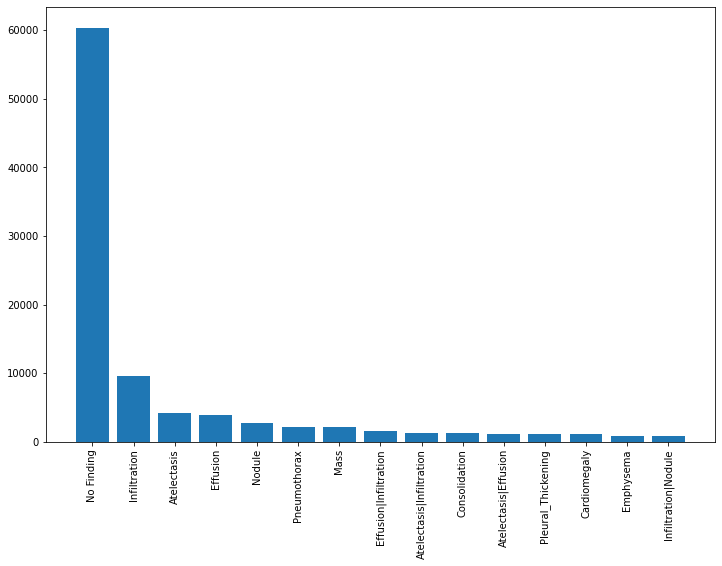

In [8]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [9]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
5664,00001527_000.png,Pleural_Thickening,0,1527,62,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
96040,00025261_002.png,Effusion|Infiltration,2,25261,58,F,PA,2642,2991,0.143,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
56178,00014006_004.png,Infiltration,4,14006,45,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [
    c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES
    ]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


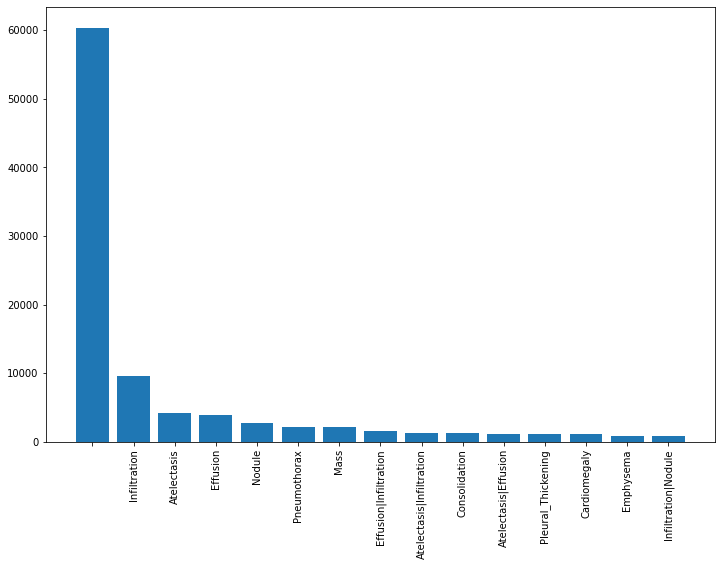

In [11]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()

all_xray_df = all_xray_df.sample(112120, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

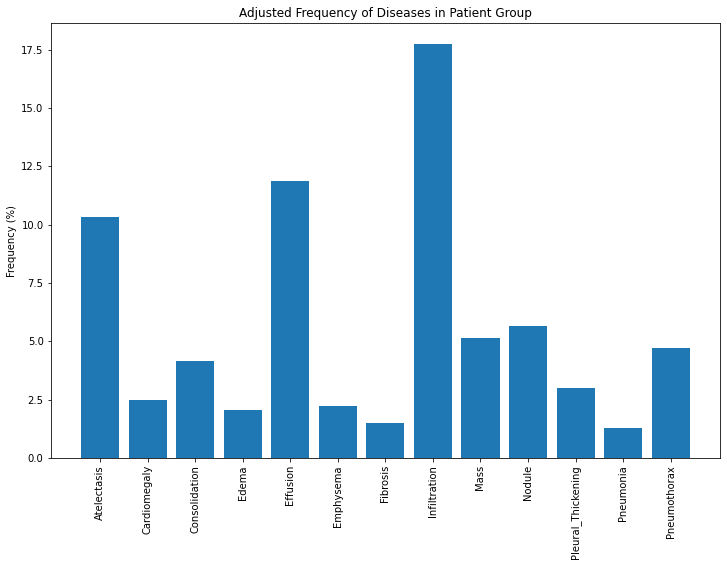

In [12]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

In [13]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [14]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec
54543,00013670_050.png,Infiltration,50,13670,56,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
20665,00005532_002.png,Infiltration,2,5532,37,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
107625,00029081_000.png,,0,29081,51,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [15]:
len(all_xray_df)

112120

### Get DataLoaders

In [16]:
class NIH_Dataset(Dataset):
  def __init__(
    self, 
    data_df,
    transform=None
    ):
    self.data_df = data_df
    self.transform = transform 

  def __len__(
    self
    ):
    return len(self.data_df)

  def __getitem__(
    self, 
    idx
    ):
    img_file = self.data_df['path'].iloc[idx]
    img = Image.open(img_file).convert('RGB')
    label = np.array(self.data_df.iloc[:,-1].iloc[idx], dtype=float)
    if self.transform:
        img = self.transform(img)

    return img, label

def get_data_loaders(
    data_df: pd.DataFrame,
    global_train_frac: float = 0.8,
    local_train_frac: float = 0.8,
    batch_size: int = 32,
    num_clients: int = 10
    ):
  train_data_transform = T.Compose([
    T.RandomRotation((-20,+20)),
    # T.Resize((512,512)),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
                ])

  test_data_transform = T.Compose([
    T.Resize((512,512)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
                ])
  
  train_df, test_df = train_test_split(
      data_df,
      test_size = 1 - global_train_frac,
      random_state = 42,
      stratify = data_df['Finding Labels'].map( lambda x: x[:4])
  )

  trainset = NIH_Dataset(
      train_df,
      transform = train_data_transform
      )
  
  testset = NIH_Dataset(
      test_df,
      transform = test_data_transform
      )

  # Split training set into `num_clients` partitions to simulate different local datasets
  partition_size = len(trainset) // num_clients
  lengths = [partition_size] * num_clients
  lengths[-1] += len(trainset) - np.sum(lengths)
  datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

  # Split each partition into train/val and create DataLoader
  trainloaders = []
  valloaders = []
  for ds in datasets:      
      len_train = math.ceil(len(ds) * local_train_frac)
      len_val = len(ds) - math.ceil(len(ds) * local_train_frac)
      lengths = [len_train, len_val]
      ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
      trainloaders.append(DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last = True))
      valloaders.append(DataLoader(ds_val, batch_size=batch_size, drop_last = True))
  testloader = DataLoader(testset, batch_size=batch_size)

  return trainloaders, valloaders, testloader

def inv_data_transform(img):
    img = img.permute(1,2,0)
    img = img * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    return img

In [17]:
num_clients = 100

trainloaders, valloaders, testloader = get_data_loaders(
    all_xray_df,
    global_train_frac = 0.95,
    local_train_frac = 0.9,
    num_clients = num_clients,
    batch_size = 25
)

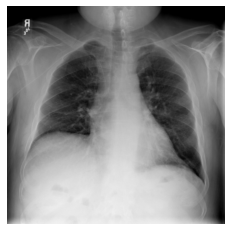

In [18]:
plt.imshow(
    inv_data_transform(
        testloader.dataset[0][0]
    )
)
plt.axis('off');

In [19]:
len(trainloaders[0].dataset), len(valloaders[0].dataset) ,len(testloader.dataset)

(959, 106, 5607)

In [20]:
len(all_labels)

13

### Basic FL utils

In [23]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.cid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=local_epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

### FL training utils

In [24]:
def compute_class_freqs(labels):

    labels = np.array(labels)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

def weighted_loss(pos_weights, neg_weights, y_pred, y_true, epsilon = 1e-7):
    y_pred = torch.sigmoid(y_pred)
    loss = 0.0
    for i in range(len(pos_weights)):
        loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:,i] * torch.log(y_pred[:,i] + epsilon))
        loss_neg = -1 * torch.mean(neg_weights[i] * (1-y_true[:,i]) * torch.log((1-y_pred[:,i]) + epsilon))
        loss += loss_pos + loss_neg
    return loss

def train(
    net,
    trainloader,
    epochs
    ):
    print(f'Entered train function, total num. of epochs: {epochs}')
    # ToDo: Class weights should be different for each client
    freq_pos, freq_neg = compute_class_freqs(all_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    valid_loss_min = np.Inf
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr = 1e-4
        )
    start_time = time.time()
    for i in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0 
        net.train()
        for j, (images, labels) in enumerate(trainloader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            ps = net(images)
            
            loss = weighted_loss(pos_weights, neg_weights, ps, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(trainloader)
        print("Epoch : {} Train Loss : {:.6f} ".format(i+1,avg_train_loss))
    end_time = time.time()
    time_delta = end_time - start_time
    print('\n')
    print(f'Time to complete local training round: {time_delta}')
    print('\n')

def test(net, testloader, pathology_list):
    
    # ToDo: Class weights should be different for each client
    freq_pos, freq_neg = compute_class_freqs(all_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    per_class_accuracy = [0 for i in range(len(pathology_list))]
    total = 0.0
    loss = 0.0
    with torch.no_grad():
        for images,labels in testloader:
            ps = net(images.to(DEVICE))
            labels = labels.to(DEVICE)
            loss += weighted_loss( pos_weights, neg_weights, ps, labels)
            ps = (ps >= 0.5).float()

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(testloader.dataset)) * 100.0 for i in per_class_accuracy]

    return loss, np.mean(per_class_accuracy)

def get_acc_data(
    class_names,
    acc_list
    ):
    df = pd.DataFrame(list(zip(class_names, acc_list)), columns =['Labels', 'Class Acc.']) 
    return df

In [25]:
def server_eval(
    server_round: int,
    parameters: fl.common.NDArrays, 
    config: Dict[str, fl.common.Scalar]
    ):
    # ToDo: Class weights should be different for each client
    freq_pos, freq_neg = compute_class_freqs(all_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    net = init_net().to(DEVICE)

    set_parameters(net, parameters)  # Update model with the latest parameters

    per_class_accuracy = [0 for i in range(len(all_labels))]
    total = 0.0
    loss = 0.0
    with torch.no_grad():
        for images,labels in testloader:
          
            ps = net(images.to(DEVICE))
            labels = labels.to(DEVICE)
            ps = (ps >= 0.5).float()

            loss += weighted_loss( pos_weights, neg_weights, ps, labels)

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(testloader.dataset))*100.0 for i in per_class_accuracy]

    test_df = get_acc_data(all_labels, per_class_accuracy)
    print('\nServer eval')
    print(test_df)
    print('\n')

    return loss,  {"mean_class_acc.": np.mean(per_class_accuracy)}

## Training

In [27]:
def init_net():
  net = models.vgg11(
    weights="IMAGENET1K_V1"
  )
  net.classifier[-1] = torch.nn.Linear(
      net.classifier[-1].in_features,
      len(all_labels)
  )
  return net

def client_fn(cid) -> FlowerClient:
    net = init_net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    print(f'Created client: {cid}')
    return FlowerClient(cid, net, trainloader, valloader)

### 35 local epochs take approx 15min. on A100 for each client

In [ ]:
num_rounds = 10
local_epochs = 35
fraction_fit = 0.05
fraction_evaluate = 0.05
min_fit_clients = 5
min_evaluate_clients = 5

client_resources = {
    "num_cpus": 1,
    "num_gpus": 1
    }

def fit_config(server_round: int):    
    config = {
        "server_round": server_round,
        "local_epochs": local_epochs,
    }
    return config

# Create an instance of the model and get the parameters
net = init_net()
params = get_parameters(init_net())

# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=num_clients,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_fn=server_eval,
    on_fit_config_fn=fit_config,
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    client_resources=client_resources,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
)

INFO flower 2022-10-21 14:35:09,457 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flower:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2022-10-21 14:35:12,366 | app.py:179 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'CPU': 12.0, 'node:172.28.0.2': 1.0, 'object_store_memory': 26778869760.0, 'memory': 53557739520.0}
INFO:flower:Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'CPU': 12.0, 'node:172.28.0.2': 1.0, 'object_store_memory': 26778869760.0, 'memory': 53557739520.0}
INFO flower 2022-10-21 14:35:12,372 | server.py:86 | Initializing global parameters
INFO:flower:Initializing global parameters
INFO flower 2022-10-21 14:35:12,374 | server.py:266 | Using initial parameters provided by strategy
INFO:flower:Using initial parameters provided by strategy
INFO flower 2022-10-21 14:35:12,376 | server.py:88 | Evaluating initial parameters
INFO:flower:Evaluating i


Server eval
                Labels  Class Acc.
0          Atelectasis   87.230248
1         Cardiomegaly   92.580703
2        Consolidation   67.522739
3                Edema   97.806314
4             Effusion   83.966470
5            Emphysema   97.663635
6             Fibrosis   95.987159
7         Infiltration   68.450152
8                 Mass   94.774389
9               Nodule   85.000892
10  Pleural_Thickening   96.201177
11           Pneumonia   98.626717
12        Pneumothorax   89.477439


(launch_and_fit pid=2109) Created client: 98
(launch_and_fit pid=2109) [Client 98, round 1] fit, config: {'server_round': 1, 'local_epochs': 35}
(launch_and_fit pid=2109) Entered train function, total num. of epochs: 35
(launch_and_fit pid=2109) Epoch : 1 Train Loss : 0.871138 
(launch_and_fit pid=2109) Epoch : 2 Train Loss : 0.834317 
(launch_and_fit pid=2109) Epoch : 3 Train Loss : 0.830534 
(launch_and_fit pid=2109) Epoch : 4 Train Loss : 0.782986 
(launch_and_fit pid=2109) Epoch : 5 Tra

DEBUG flower 2022-10-21 16:00:10,351 | server.py:234 | fit_round 1 received 5 results and 0 failures
DEBUG:flower:fit_round 1 received 5 results and 0 failures
WARNING flower 2022-10-21 16:00:18,128 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
INFO flower 2022-10-21 16:03:13,229 | server.py:122 | fit progress: (1, tensor(204.1028, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.40122923268989}, 5099.425777244)
INFO:flower:fit progress: (1, tensor(204.1028, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.40122923268989}, 5099.425777244)
DEBUG flower 2022-10-21 16:03:13,236 | server.py:170 | evaluate_round 1: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 1: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.709292
1         Cardiomegaly   97.610130
2        Consolidation   95.915820
3                Edema   97.877653
4             Effusion   88.318174
5            Emphysema   97.681470
6             Fibrosis   98.519708
7         Infiltration   81.558766
8                 Mass   95.059747
9               Nodule   94.596041
10  Pleural_Thickening   97.003745
11           Pneumonia   98.626717
12        Pneumothorax   94.738719


(scheduler +1h30m24s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +1h30m24s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flower 2022-10-21 16:03:43,431 | server.py:184 | evaluate_round 1 received 0 results and 5 failures
DEBUG:flower:evaluate_round 1 received 0 results and 5 failures
DEBUG flower 2022-10-21 16:03:43,433 | server.py:220 | fit_round 2: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 2: strategy sampled 5 clients (out of 100)


(launch_and_fit pid=4310) Created client: 80
(launch_and_fit pid=4310) [Client 80, round 2] fit, config: {'server_round': 2, 'local_epochs': 35}
(launch_and_fit pid=4310) Entered train function, total num. of epochs: 35
(launch_and_fit pid=4310) Epoch : 1 Train Loss : 0.875409 
(launch_and_fit pid=4310) Epoch : 2 Train Loss : 0.795529 
(launch_and_fit pid=4310) Epoch : 3 Train Loss : 0.788819 
(launch_and_fit pid=4310) Epoch : 4 Train Loss : 0.748520 
(launch_and_fit pid=4310) Epoch : 5 Train Loss : 0.696139 
(launch_and_fit pid=4310) Epoch : 6 Train Loss : 0.639979 
(launch_and_fit pid=4310) Epoch : 7 Train Loss : 0.593584 
(launch_and_fit pid=4310) Epoch : 8 Train Loss : 0.543762 
(launch_and_fit pid=4310) Epoch : 9 Train Loss : 0.482005 
(launch_and_fit pid=4310) Epoch : 10 Train Loss : 0.460512 
(launch_and_fit pid=4310) Epoch : 11 Train Loss : 0.404079 
(launch_and_fit pid=4310) Epoch : 12 Train Loss : 0.383754 
(launch_and_fit pid=4310) Epoch : 13 Train Loss : 0.372623 
(launch_a

DEBUG flower 2022-10-21 16:50:22,278 | server.py:234 | fit_round 2 received 3 results and 2 failures
DEBUG:flower:fit_round 2 received 3 results and 2 failures
INFO flower 2022-10-21 16:53:09,783 | server.py:122 | fit progress: (2, tensor(201.7490, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 74.73213428269608}, 8095.979252888001)
INFO:flower:fit progress: (2, tensor(201.7490, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 74.73213428269608}, 8095.979252888001)
DEBUG flower 2022-10-21 16:53:09,789 | server.py:170 | evaluate_round 2: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 2: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   80.934546
1         Cardiomegaly   93.739968
2        Consolidation   62.796504
3                Edema   95.487783
4             Effusion   86.570358
5            Emphysema   32.548600
6             Fibrosis   61.458891
7         Infiltration   71.392902
8                 Mass   91.635456
9               Nodule   81.202069
10  Pleural_Thickening   77.742108
11           Pneumonia   63.706082
12        Pneumothorax   72.302479


(launch_and_evaluate pid=5358) Created client: 46
(launch_and_evaluate pid=5358) [Client 46] evaluate, config: {}
(launch_and_evaluate pid=5444) Created client: 77
(launch_and_evaluate pid=5444) [Client 77] evaluate, config: {}
(launch_and_evaluate pid=5479) Created client: 28
(launch_and_evaluate pid=5479) [Client 28] evaluate, config: {}
(launch_and_evaluate pid=5514) Created client: 21
(launch_and_evaluate pid=5514) [Client 21] evaluate, config: {}
(launch_and_evaluate pid=5549) Created 

DEBUG flower 2022-10-21 16:53:49,288 | server.py:184 | evaluate_round 2 received 0 results and 5 failures
DEBUG:flower:evaluate_round 2 received 0 results and 5 failures
DEBUG flower 2022-10-21 16:53:49,292 | server.py:220 | fit_round 3: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 3: strategy sampled 5 clients (out of 100)


(launch_and_evaluate pid=5549) [Client 92] evaluate, config: {}
(launch_and_fit pid=5679) Created client: 7
(launch_and_fit pid=5679) [Client 7, round 3] fit, config: {'server_round': 3, 'local_epochs': 35}
(launch_and_fit pid=5679) Entered train function, total num. of epochs: 35
(launch_and_fit pid=5679) Epoch : 1 Train Loss : 0.850380 
(launch_and_fit pid=5679) Epoch : 2 Train Loss : 0.755872 
(launch_and_fit pid=5679) Epoch : 3 Train Loss : 0.688319 
(launch_and_fit pid=5679) Epoch : 4 Train Loss : 0.616137 
(launch_and_fit pid=5679) Epoch : 5 Train Loss : 0.595296 
(launch_and_fit pid=5679) Epoch : 6 Train Loss : 0.545060 
(launch_and_fit pid=5679) Epoch : 7 Train Loss : 0.467266 
(launch_and_fit pid=5679) Epoch : 8 Train Loss : 0.422285 
(launch_and_fit pid=5679) Epoch : 9 Train Loss : 0.419451 
(launch_and_fit pid=5679) Epoch : 10 Train Loss : 0.344874 
(launch_and_fit pid=5679) Epoch : 11 Train Loss : 0.303304 
(launch_and_fit pid=5679) Epoch : 12 Train Loss : 0.248263 
(launch

DEBUG flower 2022-10-21 17:25:37,296 | server.py:234 | fit_round 3 received 2 results and 3 failures
DEBUG:flower:fit_round 3 received 2 results and 3 failures
INFO flower 2022-10-21 17:28:29,511 | server.py:122 | fit progress: (3, tensor(203.7360, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 76.75570372199586}, 10215.707277522)
INFO:flower:fit progress: (3, tensor(203.7360, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 76.75570372199586}, 10215.707277522)
DEBUG flower 2022-10-21 17:28:29,518 | server.py:170 | evaluate_round 3: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 3: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   79.472088
1         Cardiomegaly   92.491528
2        Consolidation   41.555199
3                Edema   62.635991
4             Effusion   86.249331
5            Emphysema   53.272695
6             Fibrosis   87.854468
7         Infiltration   70.911361
8                 Mass   92.901730
9               Nodule   94.292848
10  Pleural_Thickening   82.504013
11           Pneumonia   64.847512
12        Pneumothorax   88.835384


(launch_and_evaluate pid=6615) Created client: 90
(launch_and_evaluate pid=6615) [Client 90] evaluate, config: {}
(launch_and_evaluate pid=6650) Created client: 89
(launch_and_evaluate pid=6650) [Client 89] evaluate, config: {}
(launch_and_evaluate pid=6687) Created client: 59
(launch_and_evaluate pid=6687) [Client 59] evaluate, config: {}
(launch_and_evaluate pid=6724) Created client: 61
(launch_and_evaluate pid=6724) [Client 61] evaluate, config: {}
(launch_and_evaluate pid=6759) Created 

DEBUG flower 2022-10-21 17:29:11,718 | server.py:184 | evaluate_round 3 received 0 results and 5 failures
DEBUG:flower:evaluate_round 3 received 0 results and 5 failures
DEBUG flower 2022-10-21 17:29:11,723 | server.py:220 | fit_round 4: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 4: strategy sampled 5 clients (out of 100)


(launch_and_evaluate pid=6759) [Client 46] evaluate, config: {}
(launch_and_fit pid=6825) Created client: 64
(launch_and_fit pid=6825) [Client 64, round 4] fit, config: {'server_round': 4, 'local_epochs': 35}
(launch_and_fit pid=6825) Entered train function, total num. of epochs: 35
(launch_and_fit pid=6825) Epoch : 1 Train Loss : 0.881114 
(launch_and_fit pid=6825) Epoch : 2 Train Loss : 0.748385 
(launch_and_fit pid=6825) Epoch : 3 Train Loss : 0.660859 
(launch_and_fit pid=6825) Epoch : 4 Train Loss : 0.619090 
(launch_and_fit pid=6825) Epoch : 5 Train Loss : 0.554530 
(launch_and_fit pid=6825) Epoch : 6 Train Loss : 0.523645 
(launch_and_fit pid=6825) Epoch : 7 Train Loss : 0.450298 
(launch_and_fit pid=6825) Epoch : 8 Train Loss : 0.392610 
(launch_and_fit pid=6825) Epoch : 9 Train Loss : 0.351351 
(launch_and_fit pid=6825) Epoch : 10 Train Loss : 0.295052 
(launch_and_fit pid=6825) Epoch : 11 Train Loss : 0.258434 
(launch_and_fit pid=6825) Epoch : 12 Train Loss : 0.234228 
(laun

DEBUG flower 2022-10-21 18:17:14,563 | server.py:234 | fit_round 4 received 3 results and 2 failures
DEBUG:flower:fit_round 4 received 3 results and 2 failures
INFO flower 2022-10-21 18:20:07,926 | server.py:122 | fit progress: (4, tensor(202.5287, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 77.32779081093688}, 13314.122095123)
INFO:flower:fit progress: (4, tensor(202.5287, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 77.32779081093688}, 13314.122095123)
DEBUG flower 2022-10-21 18:20:07,931 | server.py:170 | evaluate_round 4: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 4: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   79.917960
1         Cardiomegaly   96.968076
2        Consolidation   85.999643
3                Edema   67.433565
4             Effusion   87.979312
5            Emphysema   56.911004
6             Fibrosis   74.514000
7         Infiltration   74.496166
8                 Mass   89.709292
9               Nodule   92.794721
10  Pleural_Thickening   80.381666
11           Pneumonia   34.456929
12        Pneumothorax   83.698948


(launch_and_evaluate pid=8098) Created client: 79
(launch_and_evaluate pid=8098) [Client 79] evaluate, config: {}
(launch_and_evaluate pid=8134) Created client: 38
(launch_and_evaluate pid=8134) [Client 38] evaluate, config: {}
(launch_and_evaluate pid=8169) Created client: 93
(launch_and_evaluate pid=8169) [Client 93] evaluate, config: {}
(launch_and_evaluate pid=8204) Created client: 34


DEBUG flower 2022-10-21 18:20:45,115 | server.py:184 | evaluate_round 4 received 0 results and 5 failures
DEBUG:flower:evaluate_round 4 received 0 results and 5 failures
DEBUG flower 2022-10-21 18:20:45,120 | server.py:220 | fit_round 5: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 5: strategy sampled 5 clients (out of 100)


(launch_and_evaluate pid=8204) [Client 34] evaluate, config: {}
(launch_and_fit pid=8294) Created client: 52
(launch_and_fit pid=8294) [Client 52, round 5] fit, config: {'server_round': 5, 'local_epochs': 35}
(launch_and_fit pid=8294) Entered train function, total num. of epochs: 35
(launch_and_fit pid=8294) Epoch : 1 Train Loss : 0.930622 
(launch_and_fit pid=8294) Epoch : 2 Train Loss : 0.762377 
(launch_and_fit pid=8294) Epoch : 3 Train Loss : 0.683026 
(launch_and_fit pid=8294) Epoch : 4 Train Loss : 0.600600 
(launch_and_fit pid=8294) Epoch : 5 Train Loss : 0.542959 
(launch_and_fit pid=8294) Epoch : 6 Train Loss : 0.502190 
(launch_and_fit pid=8294) Epoch : 7 Train Loss : 0.450535 
(launch_and_fit pid=8294) Epoch : 8 Train Loss : 0.418545 
(launch_and_fit pid=8294) Epoch : 9 Train Loss : 0.391732 
(launch_and_fit pid=8294) Epoch : 10 Train Loss : 0.339191 
(launch_and_fit pid=8294) Epoch : 11 Train Loss : 0.267634 
(launch_and_fit pid=8294) Epoch : 12 Train Loss : 0.256971 
(laun

DEBUG flower 2022-10-21 19:24:59,056 | server.py:234 | fit_round 5 received 4 results and 1 failures
DEBUG:flower:fit_round 5 received 4 results and 1 failures
INFO flower 2022-10-21 19:27:55,186 | server.py:122 | fit progress: (5, tensor(203.5606, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 72.82380540807506}, 17381.382370312)
INFO:flower:fit progress: (5, tensor(203.5606, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 72.82380540807506}, 17381.382370312)
DEBUG flower 2022-10-21 19:27:55,193 | server.py:170 | evaluate_round 5: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 5: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   80.399501
1         Cardiomegaly   92.224006
2        Consolidation   90.155163
3                Edema   66.559658
4             Effusion   86.392010
5            Emphysema   18.673087
6             Fibrosis   77.367576
7         Infiltration   80.292492
8                 Mass   92.491528
9               Nodule   94.007491
10  Pleural_Thickening   57.945425
11           Pneumonia   18.762261
12        Pneumothorax   91.439272


(launch_and_evaluate pid=9812) Created client: 95
(launch_and_evaluate pid=9812) [Client 95] evaluate, config: {}
(launch_and_evaluate pid=9847) Created client: 59


DEBUG flower 2022-10-21 19:28:30,207 | server.py:184 | evaluate_round 5 received 0 results and 5 failures
DEBUG:flower:evaluate_round 5 received 0 results and 5 failures
DEBUG flower 2022-10-21 19:28:30,211 | server.py:220 | fit_round 6: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 6: strategy sampled 5 clients (out of 100)


(launch_and_evaluate pid=9847) [Client 59] evaluate, config: {}
(launch_and_fit pid=9913) Created client: 86
(launch_and_fit pid=9913) [Client 86, round 6] fit, config: {'server_round': 6, 'local_epochs': 35}
(launch_and_fit pid=9913) Entered train function, total num. of epochs: 35
(launch_and_fit pid=10045) Created client: 71
(launch_and_fit pid=10045) [Client 71, round 6] fit, config: {'server_round': 6, 'local_epochs': 35}
(launch_and_fit pid=10045) Entered train function, total num. of epochs: 35
(launch_and_fit pid=10082) Created client: 26
(launch_and_fit pid=10082) [Client 26, round 6] fit, config: {'server_round': 6, 'local_epochs': 35}
(launch_and_fit pid=10082) Entered train function, total num. of epochs: 35
(launch_and_fit pid=10082) Epoch : 1 Train Loss : 0.870468 
(launch_and_fit pid=10082) Epoch : 2 Train Loss : 0.733879 
(launch_and_fit pid=10082) Epoch : 3 Train Loss : 0.641814 
(launch_and_fit pid=10082) Epoch : 4 Train Loss : 0.591246 
(launch_and_fit pid=10082) Epo

DEBUG flower 2022-10-21 20:01:05,022 | server.py:234 | fit_round 6 received 2 results and 3 failures
DEBUG:flower:fit_round 6 received 2 results and 3 failures
INFO flower 2022-10-21 20:03:56,392 | server.py:122 | fit progress: (6, tensor(204.0399, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 81.53818715616468}, 19542.588419845)
INFO:flower:fit progress: (6, tensor(204.0399, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 81.53818715616468}, 19542.588419845)
DEBUG flower 2022-10-21 20:03:56,398 | server.py:170 | evaluate_round 6: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 6: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   85.518102
1         Cardiomegaly   97.449617
2        Consolidation   59.907259
3                Edema   92.830391
4             Effusion   88.104156
5            Emphysema   32.191903
6             Fibrosis   88.478687
7         Infiltration   81.469592
8                 Mass   86.784377
9               Nodule   94.150169
10  Pleural_Thickening   88.282504
11           Pneumonia   72.552167
12        Pneumothorax   92.277510


(launch_and_evaluate pid=10850) Created client: 69
(launch_and_evaluate pid=10850) [Client 69] evaluate, config: {}
(scheduler +5h31m6s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_and_evaluate pid=10885) Created client: 12
(launch_and_evaluate pid=10885) [Client 12] evaluate, config: {}
(la

DEBUG flower 2022-10-21 20:04:37,982 | server.py:184 | evaluate_round 6 received 0 results and 5 failures
DEBUG:flower:evaluate_round 6 received 0 results and 5 failures
DEBUG flower 2022-10-21 20:04:37,986 | server.py:220 | fit_round 7: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 7: strategy sampled 5 clients (out of 100)


(launch_and_evaluate pid=10991) [Client 80] evaluate, config: {}
(launch_and_fit pid=11063) Created client: 85
(launch_and_fit pid=11063) [Client 85, round 7] fit, config: {'server_round': 7, 'local_epochs': 35}
(launch_and_fit pid=11063) Entered train function, total num. of epochs: 35
(launch_and_fit pid=11063) Epoch : 1 Train Loss : 1.015137 
(launch_and_fit pid=11063) Epoch : 2 Train Loss : 0.772295 
(launch_and_fit pid=11063) Epoch : 3 Train Loss : 0.700685 
(launch_and_fit pid=11063) Epoch : 4 Train Loss : 0.635635 
(launch_and_fit pid=11063) Epoch : 5 Train Loss : 0.589913 
(launch_and_fit pid=11063) Epoch : 6 Train Loss : 0.529047 
(launch_and_fit pid=11063) Epoch : 7 Train Loss : 0.507417 
(launch_and_fit pid=11063) Epoch : 8 Train Loss : 0.459688 
(launch_and_fit pid=11063) Epoch : 9 Train Loss : 0.375017 
(launch_and_fit pid=11063) Epoch : 10 Train Loss : 0.344846 
(launch_and_fit pid=11063) Epoch : 11 Train Loss : 0.318680 
(launch_and_fit pid=11063) Epoch : 12 Train Loss :

### 2 local epochs

In [ ]:
num_rounds = 1
local_epochs = 2
fraction_fit = 0.1
fraction_evaluate = 0.1
min_fit_clients = 1
min_evaluate_clients = 1

client_resources = {
    "num_cpus": 1,
    "num_gpus": 1
    }

def fit_config(server_round: int):    
    config = {
        "server_round": server_round,
        "local_epochs": local_epochs,
    }
    return config

# Create an instance of the model and get the parameters
net = init_net()
params = get_parameters(init_net())

# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=num_clients,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_fn=server_eval,
    on_fit_config_fn=fit_config,
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    client_resources=client_resources,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
)

INFO flower 2022-10-20 12:26:33,666 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO:flower:Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flower 2022-10-20 12:26:39,088 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:172.28.0.2': 1.0, 'object_store_memory': 26786764800.0, 'memory': 53573529600.0, 'GPU': 1.0, 'CPU': 12.0}
INFO:flower:Flower VCE: Ray initialized with resources: {'node:172.28.0.2': 1.0, 'object_store_memory': 26786764800.0, 'memory': 53573529600.0, 'GPU': 1.0, 'CPU': 12.0}
INFO flower 2022-10-20 12:26:39,091 | server.py:86 | Initializing global parameters
INFO:flower:Initializing global parameters
INFO flower 2022-10-20 12:26:39,096 | server.py:266 | Using initial parameters provided by strategy
INFO:flower:Using initial parameters provided by strategy
INFO flower 2022-10-20 12:26:39,099 | server.py:88 | Evaluating initial parameters
INFO:flower:Evaluating ini


Server eval
                Labels  Class Acc.
0          Atelectasis   86.017478
1         Cardiomegaly   95.969324
2        Consolidation   90.137328
3                Edema   89.637953
4             Effusion   85.428928
5            Emphysema   97.717139
6             Fibrosis   98.430533
7         Infiltration   60.246121
8                 Mass   91.706795
9               Nodule   91.760300
10  Pleural_Thickening   94.239344
11           Pneumonia   94.845729
12        Pneumothorax   94.257179


(launch_and_fit pid=12888) Created client: 6
(launch_and_fit pid=12888) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 2}
(launch_and_fit pid=12888) Entered train function, total num. of epochs: 2
(launch_and_fit pid=12888) Iteration 0, loss: 0.9309484082780329
(launch_and_fit pid=12888) Iteration 100, loss: 0.8324902877098763
(launch_and_fit pid=12888) Iteration 200, loss: 0.8417237977649786
(launch_and_fit pid=12888) Iteration 300, loss: 0.6053079236463453
(launch_an

DEBUG flower 2022-10-20 12:38:35,539 | server.py:234 | fit_round 1 received 1 results and 0 failures
DEBUG:flower:fit_round 1 received 1 results and 0 failures
WARNING flower 2022-10-20 12:38:37,080 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
INFO flower 2022-10-20 12:41:26,336 | server.py:122 | fit progress: (1, tensor(202.5730, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 92.39961037713846}, 716.7872724610006)
INFO:flower:fit progress: (1, tensor(202.5730, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 92.39961037713846}, 716.7872724610006)
DEBUG flower 2022-10-20 12:41:26,343 | server.py:170 | evaluate_round 1: strategy sampled 1 clients (out of 10)
DEBUG:flower:evaluate_round 1: strategy sampled 1 clients (out of 10)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.530943
1         Cardiomegaly   96.379526
2        Consolidation   87.034065
3                Edema   87.479936
4             Effusion   87.997146
5            Emphysema   97.467451
6             Fibrosis   98.537542
7         Infiltration   78.259319
8                 Mass   94.756554
9               Nodule   93.044409
10  Pleural_Thickening   96.843232
11           Pneumonia   98.822900
12        Pneumothorax   95.041912


(launch_and_evaluate pid=13140) Created client: 7


DEBUG flower 2022-10-20 12:41:34,748 | server.py:184 | evaluate_round 1 received 0 results and 1 failures
DEBUG:flower:evaluate_round 1 received 0 results and 1 failures
INFO flower 2022-10-20 12:41:34,751 | server.py:144 | FL finished in 725.2018406299994
INFO:flower:FL finished in 725.2018406299994
INFO flower 2022-10-20 12:41:34,765 | app.py:180 | app_fit: losses_distributed []
INFO:flower:app_fit: losses_distributed []
INFO flower 2022-10-20 12:41:34,767 | app.py:181 | app_fit: metrics_distributed {}
INFO:flower:app_fit: metrics_distributed {}
INFO flower 2022-10-20 12:41:34,775 | app.py:182 | app_fit: losses_centralized [(0, tensor(208.0653, device='cuda:0', dtype=torch.float64)), (1, tensor(202.5730, device='cuda:0', dtype=torch.float64))]
INFO:flower:app_fit: losses_centralized [(0, tensor(208.0653, device='cuda:0', dtype=torch.float64)), (1, tensor(202.5730, device='cuda:0', dtype=torch.float64))]
INFO flower 2022-10-20 12:41:34,777 | app.py:183 | app_fit: metrics_centralized {

(launch_and_evaluate pid=13140) [Client 7] evaluate, config: {}


History (loss, centralized):
	round 0: 208.06525430734155
	round 1: 202.57301380878866
History (metrics, centralized):
{'mean_class_acc.': [(0, 90.03031924380238), (1, 92.39961037713846)]}

### 5 local epochs

In [ ]:
num_rounds = 1
local_epochs = 5
fraction_fit = 0.1
fraction_evaluate = 0.1
min_fit_clients = 1
min_evaluate_clients = 1

client_resources = {
    "num_cpus": 1,
    "num_gpus": 1
    }

def fit_config(server_round: int):    
    config = {
        "server_round": server_round,
        "local_epochs": local_epochs,
    }
    return config

# Create an instance of the model and get the parameters
net = init_net()
params = get_parameters(init_net())

# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=num_clients,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_fn=server_eval,
    on_fit_config_fn=fit_config,
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    client_resources=client_resources,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
)

INFO flower 2022-10-20 12:41:38,040 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO:flower:Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flower 2022-10-20 12:41:43,835 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 53587621479.0, 'node:172.28.0.2': 1.0, 'CPU': 12.0, 'GPU': 1.0, 'object_store_memory': 26793810739.0}
INFO:flower:Flower VCE: Ray initialized with resources: {'memory': 53587621479.0, 'node:172.28.0.2': 1.0, 'CPU': 12.0, 'GPU': 1.0, 'object_store_memory': 26793810739.0}
INFO flower 2022-10-20 12:41:43,839 | server.py:86 | Initializing global parameters
INFO:flower:Initializing global parameters
INFO flower 2022-10-20 12:41:43,841 | server.py:266 | Using initial parameters provided by strategy
INFO:flower:Using initial parameters provided by strategy
INFO flower 2022-10-20 12:41:43,844 | server.py:88 | Evaluating initial parameters
INFO:flower:Evaluating ini


Server eval
                Labels  Class Acc.
0          Atelectasis   79.686107
1         Cardiomegaly   96.718388
2        Consolidation   91.992153
3                Edema   96.486535
4             Effusion   86.070983
5            Emphysema   95.666132
6             Fibrosis   73.871946
7         Infiltration   78.419832
8                 Mass   90.101659
9               Nodule   93.062244
10  Pleural_Thickening   96.843232
11           Pneumonia   72.498662
12        Pneumothorax   94.720885


(launch_and_fit pid=13727) Created client: 9
(launch_and_fit pid=13727) [Client 9, round 1] fit, config: {'server_round': 1, 'local_epochs': 5}
(launch_and_fit pid=13727) Entered train function, total num. of epochs: 5
(launch_and_fit pid=13727) Iteration 0, loss: 0.9482084653389974
(launch_and_fit pid=13727) Iteration 100, loss: 0.8389463463245527
(launch_and_fit pid=13727) Iteration 200, loss: 1.0179940503594536
(launch_and_fit pid=13727) Iteration 300, loss: 0.8457128192347327
(launch_an

DEBUG flower 2022-10-20 13:06:55,625 | server.py:234 | fit_round 1 received 1 results and 0 failures
DEBUG:flower:fit_round 1 received 1 results and 0 failures
WARNING flower 2022-10-20 13:06:57,048 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
INFO flower 2022-10-20 13:09:45,547 | server.py:122 | fit progress: (1, tensor(200.0230, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 82.73449397044902}, 1512.0466323359997)
INFO:flower:fit progress: (1, tensor(200.0230, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 82.73449397044902}, 1512.0466323359997)
DEBUG flower 2022-10-20 13:09:45,552 | server.py:170 | evaluate_round 1: strategy sampled 1 clients (out of 10)
DEBUG:flower:evaluate_round 1: strategy sampled 1 clients (out of 10)



Server eval
                Labels  Class Acc.
0          Atelectasis   74.549670
1         Cardiomegaly   87.890137
2        Consolidation   90.137328
3                Edema   75.138220
4             Effusion   83.912966
5            Emphysema   66.167291
6             Fibrosis   95.041912
7         Infiltration   79.061887
8                 Mass   84.269663
9               Nodule   88.764045
10  Pleural_Thickening   90.850722
11           Pneumonia   77.135723
12        Pneumothorax   82.628857


(launch_and_evaluate pid=14147) Created client: 9


DEBUG flower 2022-10-20 13:09:54,055 | server.py:184 | evaluate_round 1 received 0 results and 1 failures
DEBUG:flower:evaluate_round 1 received 0 results and 1 failures
INFO flower 2022-10-20 13:09:54,058 | server.py:144 | FL finished in 1520.5584351079997
INFO:flower:FL finished in 1520.5584351079997
INFO flower 2022-10-20 13:09:54,066 | app.py:180 | app_fit: losses_distributed []
INFO:flower:app_fit: losses_distributed []
INFO flower 2022-10-20 13:09:54,069 | app.py:181 | app_fit: metrics_distributed {}
INFO:flower:app_fit: metrics_distributed {}
INFO flower 2022-10-20 13:09:54,079 | app.py:182 | app_fit: losses_centralized [(0, tensor(206.2325, device='cuda:0', dtype=torch.float64)), (1, tensor(200.0230, device='cuda:0', dtype=torch.float64))]
INFO:flower:app_fit: losses_centralized [(0, tensor(206.2325, device='cuda:0', dtype=torch.float64)), (1, tensor(200.0230, device='cuda:0', dtype=torch.float64))]
INFO flower 2022-10-20 13:09:54,081 | app.py:183 | app_fit: metrics_centralized

(launch_and_evaluate pid=14147) [Client 9] evaluate, config: {}


History (loss, centralized):
	round 0: 206.23245081118296
	round 1: 200.02300080857603
History (metrics, centralized):
{'mean_class_acc.': [(0, 88.16451962519379), (1, 82.73449397044902)]}

### 10 local epochs

In [ ]:
num_rounds = 1
local_epochs = 10
fraction_fit = 0.1
fraction_evaluate = 0.1
min_fit_clients = 1
min_evaluate_clients = 1

client_resources = {
    "num_cpus": 1,
    "num_gpus": 1
    }

def fit_config(server_round: int):    
    config = {
        "server_round": server_round,
        "local_epochs": local_epochs,
    }
    return config

# Create an instance of the model and get the parameters
net = init_net()
params = get_parameters(init_net())

# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=num_clients,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_fn=server_eval,
    on_fit_config_fn=fit_config,
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    client_resources=client_resources,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy
)

INFO flower 2022-10-20 13:22:25,665 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO:flower:Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flower 2022-10-20 13:22:31,046 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 12.0, 'node:172.28.0.2': 1.0, 'GPU': 1.0, 'memory': 53577036596.0, 'object_store_memory': 26788518297.0}
INFO:flower:Flower VCE: Ray initialized with resources: {'CPU': 12.0, 'node:172.28.0.2': 1.0, 'GPU': 1.0, 'memory': 53577036596.0, 'object_store_memory': 26788518297.0}
INFO flower 2022-10-20 13:22:31,049 | server.py:86 | Initializing global parameters
INFO:flower:Initializing global parameters
INFO flower 2022-10-20 13:22:31,052 | server.py:266 | Using initial parameters provided by strategy
INFO:flower:Using initial parameters provided by strategy
INFO flower 2022-10-20 13:22:31,054 | server.py:88 | Evaluating initial parameters
INFO:flower:Evaluating ini


Server eval
                Labels  Class Acc.
0          Atelectasis   89.637953
1         Cardiomegaly   95.541288
2        Consolidation   70.857856
3                Edema   61.655074
4             Effusion   86.695202
5            Emphysema   94.078830
6             Fibrosis   93.115748
7         Infiltration   81.273408
8                 Mass   76.333155
9               Nodule   86.677368
10  Pleural_Thickening   95.487783
11           Pneumonia   88.050651
12        Pneumothorax   81.041555


(launch_and_fit pid=14969) Created client: 5
(launch_and_fit pid=14969) [Client 5, round 1] fit, config: {'server_round': 1, 'local_epochs': 10}
(launch_and_fit pid=14969) Entered train function, total num. of epochs: 10
(launch_and_fit pid=14969) Iteration 0, loss: 0.9188192104641673
(launch_and_fit pid=14969) Iteration 100, loss: 0.9840345188161964
(launch_and_fit pid=14969) Iteration 200, loss: 1.132933603131884
(launch_and_fit pid=14969) Iteration 300, loss: 0.9347548807273508
(launch_a

DEBUG flower 2022-10-20 14:10:53,288 | server.py:234 | fit_round 1 received 1 results and 0 failures
DEBUG:flower:fit_round 1 received 1 results and 0 failures
WARNING flower 2022-10-20 14:10:54,699 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
INFO flower 2022-10-20 14:13:46,115 | server.py:122 | fit progress: (1, tensor(201.9923, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 92.08132691278759}, 2899.1638341159996)
INFO:flower:fit progress: (1, tensor(201.9923, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 92.08132691278759}, 2899.1638341159996)
DEBUG flower 2022-10-20 14:13:46,122 | server.py:170 | evaluate_round 1: strategy sampled 1 clients (out of 10)
DEBUG:flower:evaluate_round 1: strategy sampled 1 clients (out of 10)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.530943
1         Cardiomegaly   97.306938
2        Consolidation   88.246834
3                Edema   95.077582
4             Effusion   87.979312
5            Emphysema   94.560371
6             Fibrosis   95.238095
7         Infiltration   78.972713
8                 Mass   94.364188
9               Nodule   92.277510
10  Pleural_Thickening   96.040663
11           Pneumonia   95.238095
12        Pneumothorax   92.224006


(launch_and_evaluate pid=15841) Created client: 3


DEBUG flower 2022-10-20 14:13:54,674 | server.py:184 | evaluate_round 1 received 0 results and 1 failures
DEBUG:flower:evaluate_round 1 received 0 results and 1 failures
INFO flower 2022-10-20 14:13:54,677 | server.py:144 | FL finished in 2907.725865247001
INFO:flower:FL finished in 2907.725865247001
INFO flower 2022-10-20 14:13:54,688 | app.py:180 | app_fit: losses_distributed []
INFO:flower:app_fit: losses_distributed []
INFO flower 2022-10-20 14:13:54,691 | app.py:181 | app_fit: metrics_distributed {}
INFO:flower:app_fit: metrics_distributed {}
INFO flower 2022-10-20 14:13:54,700 | app.py:182 | app_fit: losses_centralized [(0, tensor(207.0864, device='cuda:0', dtype=torch.float64)), (1, tensor(201.9923, device='cuda:0', dtype=torch.float64))]
INFO:flower:app_fit: losses_centralized [(0, tensor(207.0864, device='cuda:0', dtype=torch.float64)), (1, tensor(201.9923, device='cuda:0', dtype=torch.float64))]
INFO flower 2022-10-20 14:13:54,702 | app.py:183 | app_fit: metrics_centralized {

(launch_and_evaluate pid=15841) [Client 3] evaluate, config: {}


History (loss, centralized):
	round 0: 207.0864017368368
	round 1: 201.99226647068295
History (metrics, centralized):
{'mean_class_acc.': [(0, 84.6496824024914), (1, 92.08132691278759)]}